# Should covariance entry increase to infinity?

Should the traffic model proposed is correct, the variance will continuously increase with time. But intuition says it should be bounded, since the road boundary is specified, and physical constraints are available.

To deal with this, we run the FPCA for longer period of time, say 1 minute of trajectory.

# Preambles

In [5]:
%load_ext autoreload
%autoreload 2

import sys 
# sys.path.append("/Users/thinhhoang/Documents/anomaly-detection-ngsim")
sys.path.append("C:\\Users\\nxf67027\\Documents\\anomaly-detection-ngsim")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from seig import eig as eig

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data from Pickled file

To restore variables, run this code:

In [6]:
import pickle

with open('prepare_trajectories_long.pkl', 'rb') as handle:
    pkl_obj = pickle.load(handle)
    container_t_np = pkl_obj['t']
    container_x_np = pkl_obj['x']
    container_y_np = pkl_obj['y']
    print('Data loaded from file')

num_of_trajs = container_y_np.shape[0]

Data loaded from file


# Global FPCA decomposition for Y component

In [7]:
import sklearn
import skfda

%matplotlib inline

Convert the data to appropriate type for the skfda package

In [8]:
fdgrx = skfda.FDataGrid(container_x_np, np.arange(container_x_np.shape[1]))
fdgry = skfda.FDataGrid(container_y_np, np.arange(container_y_np.shape[1]))
# here we don't use the container_t_np vector since we don't want it to mess up the unit

In [9]:
# from skfda.exploratory.visualization import plot_fpca_perturbation_graphs
from skfda.preprocessing.dim_reduction.projection import FPCA

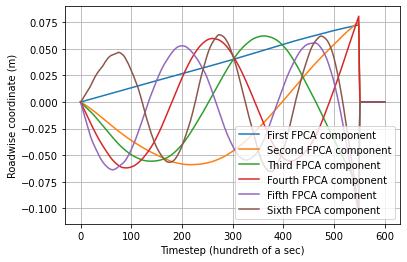

In [10]:
fpca_y = FPCA(n_components=6)
fpca_y.fit(fdgry)
fpca_y.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
plt.legend(['First FPCA component', 'Second FPCA component', 'Third FPCA component', 'Fourth FPCA component', 'Fifth FPCA component', 'Sixth FPCA component'])
print('')

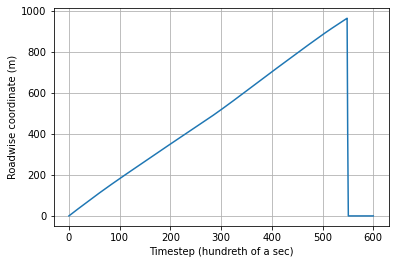

In [11]:
fpca_y.mean_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
print('')
mean_y = fpca_y.mean_.data_matrix.reshape((-1))

[9.72844194e-01 1.94798473e-02 5.41338586e-03 1.66647931e-03
 3.39176335e-04 1.38736281e-04]


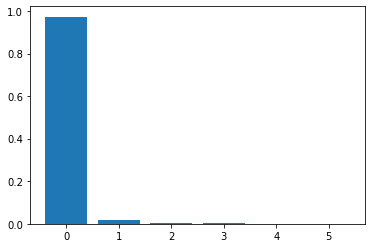

In [12]:
plt.bar(np.arange(6), fpca_y.explained_variance_ratio_)
print(fpca_y.explained_variance_ratio_)

# Global FPCA decomposition for X component

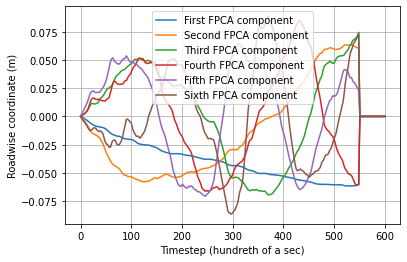

In [13]:
fpca_x = FPCA(n_components=6)
fpca_x.fit(fdgrx)
fpca_x.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
plt.legend(['First FPCA component', 'Second FPCA component', 'Third FPCA component', 'Fourth FPCA component', 'Fifth FPCA component', 'Sixth FPCA component'])
print('')

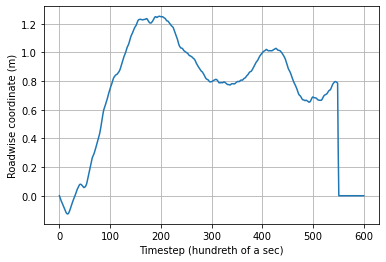

In [14]:
fpca_x.mean_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
print('')
mean_x = fpca_x.mean_.data_matrix.reshape((-1))

[0.82285495 0.10297058 0.03187095 0.01343626 0.01043935 0.00493844]


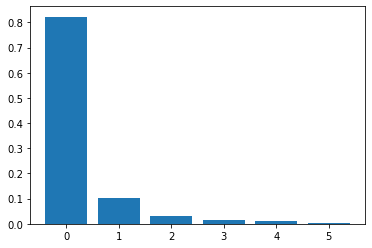

In [15]:
plt.bar(np.arange(6), fpca_x.explained_variance_ratio_)
print(fpca_x.explained_variance_ratio_)

# Get the representations

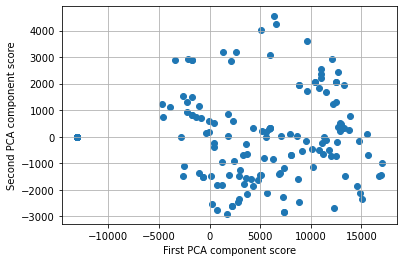

In [16]:
y_basis = fpca_y.components_.data_matrix.squeeze().transpose()
y_coeffs = np.matmul(container_y_np - mean_y, y_basis)
plt.scatter(y_coeffs[:,0], y_coeffs[:,1])
plt.xlabel('First PCA component score')
plt.ylabel('Second PCA component score')
plt.grid(True)

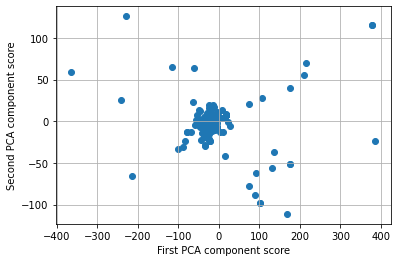

In [17]:
x_basis = fpca_x.components_.data_matrix.squeeze().transpose()
x_coeffs = np.matmul(container_x_np - mean_x, x_basis)
plt.scatter(x_coeffs[:,0], x_coeffs[:,1])
plt.xlabel('First PCA component score')
plt.ylabel('Second PCA component score')
plt.grid(True)

# Zero-meaned trajectories

This might be helpful in analytically finding the basis for the trajectory (which we are suspicious that it is a Fourier basis).

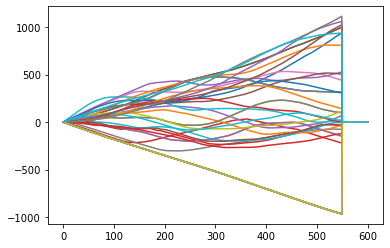

In [39]:
for i in np.random.choice(num_of_trajs, 40):
    traj_to_plot = container_y_np[i] - mean_y
    plt.plot(traj_to_plot)

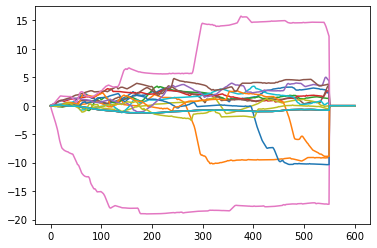

In [40]:

for i in np.random.choice(num_of_trajs, 20):
    traj_to_plot = container_x_np[i] - mean_x
    plt.plot(traj_to_plot)

# Y trajectories: contribution by PCA component

Original trajectories:

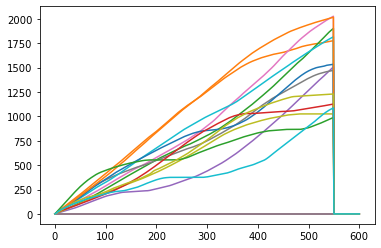

In [41]:
for i in np.random.choice(num_of_trajs, 20):
    traj_to_plot = container_y_np[i]
    plt.plot(traj_to_plot)

Mean removed:

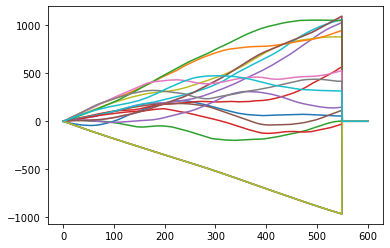

In [42]:
for i in np.random.choice(num_of_trajs, 20):
    traj_to_plot = container_y_np[i] - mean_y
    plt.plot(traj_to_plot)

Mean and 1st removed:

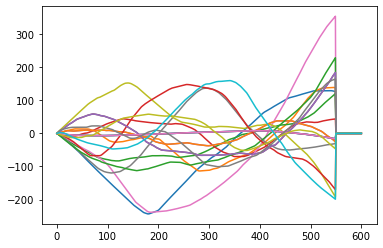

In [43]:
for i in np.random.choice(num_of_trajs, 20):
    traj_to_plot = container_y_np[i] - mean_y - y_coeffs[i,0] * y_basis[:,0]
    plt.plot(traj_to_plot)

Mean, 1st and 2nd removed

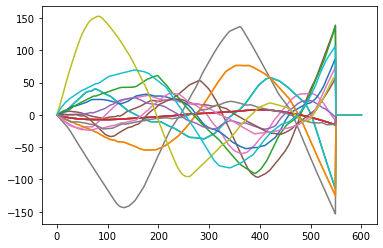

In [44]:
for i in np.random.choice(num_of_trajs, 20):
    traj_to_plot = container_y_np[i] - mean_y - y_coeffs[i,0] * y_basis[:,0] - y_coeffs[i,1] * y_basis[:,1]
    plt.plot(traj_to_plot)

# Covariance matrix

In [49]:
y_cov = fdgry.cov().data_matrix[0,:550,:550,0]

(0.0, 549.0, 0.0, 549.0)

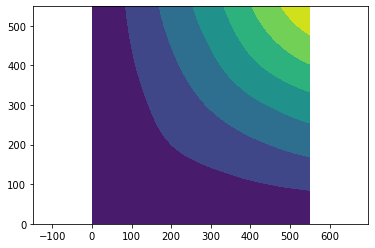

In [50]:
plt.contourf(y_cov)
plt.axis('equal')

# $Cov(X_t, X_t)$

The diagonal of the covariance matrix:

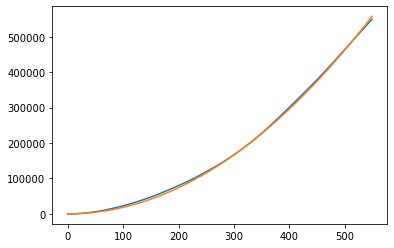

In [56]:
y_cov_diag = np.zeros((550,))
for i in range(550):
    y_cov_diag[i] = y_cov[i,i]
plt.plot(y_cov_diag)
plt.plot(np.arange(550)*np.arange(550)*1.85)

So the covariance matrix seems to grow "exponentially". To check, let's plot out the log:

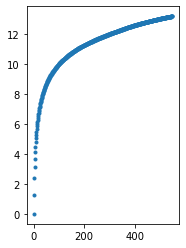

In [57]:
plt.subplot(1,2,1)
y_cov_diag_lg = np.zeros((550,))
for i in range(550):
    y_cov_diag_lg[i] = np.log(y_cov[i,i]+1)
plt.plot(y_cov_diag_lg, '.')

First derivative:

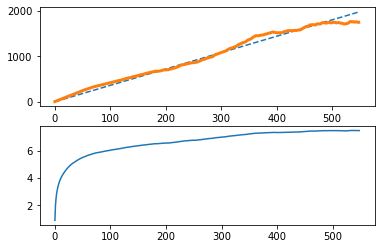

In [83]:

plt.subplot(2,1,1)
plt.plot(np.arange(550)*3.6, linestyle='--')
plt.plot(np.diff(y_cov_diag), linewidth=3)
plt.subplot(2,1,2)
plt.plot(np.log(np.diff(y_cov_diag)))

Second derivative:

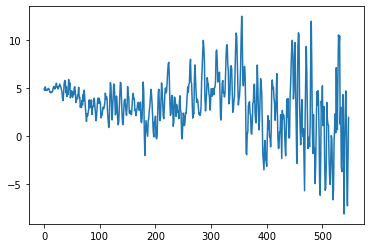

In [94]:
#plt.subplot(2,1,1)
plt.plot(np.diff(np.diff(y_cov_diag)))
#plt.subplot(2,1,2)
#plt.plot(np.log(np.diff(np.diff(y_cov_diag))))

In [85]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

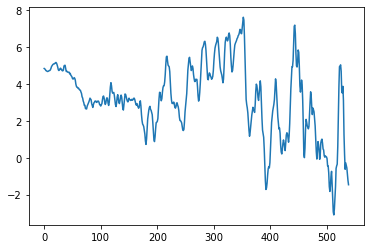

In [95]:
plt.plot(moving_average(np.diff(np.diff(y_cov_diag)), 10))

So there is a tapering effect after 40s. The variance becomes more like constant rather than linear growth. As predicted, the variance of the velocity cannot increase to infinity. This is expected because the vehicle velocity must stay bounded.

# First derivative of the trajectory

If the model is to be believed, then we would expect a Wiener process.

(-5.0, 5.0)

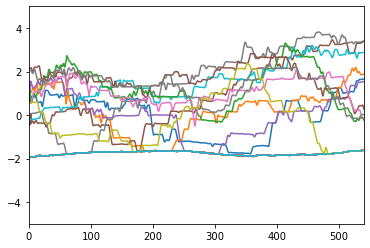

In [70]:
for i in np.random.choice(num_of_trajs, 20):
    plt.plot(np.diff(container_y_np[i] - mean_y))
plt.xlim((0,540))
plt.ylim((-5,5))

(0.0, 544.0, 0.0, 544.0)

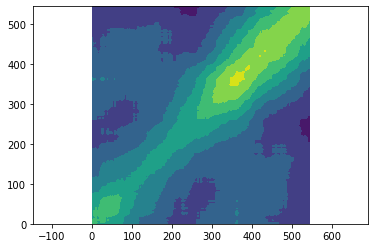

In [73]:
fdgrv = skfda.FDataGrid(np.diff(container_y_np - mean_y), np.arange(container_y_np.shape[1]-1))
cov_mtrxv = fdgrv.cov().data_matrix[0,:545,:545,0]
plt.contourf(cov_mtrxv)
plt.axis('equal')

Is this close to a Wiener process? Check out the second derivative:

(-0.4, 0.4)

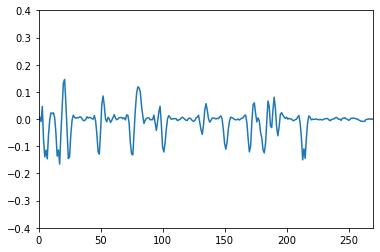

In [98]:
for i in np.random.choice(num_of_trajs, 1):
    plt.plot(np.diff(np.diff(container_y_np[i] - mean_y)))
plt.xlim((0,270))
plt.ylim((-0.4,0.4))

Looks like could be approximated by a Gaussian white noise?